# Koln Traffic Regulator with Parallel Computing

Our work starts from a project jointly developed by IBM and by the German city of Koln thought
to be a first step towards traffic regulation and an efficient exploitation of transport’s resources.
The mobility is emulated with SUMO, an open-source traffic simulation suite which allows generating the
movement around a predefined city road map, extracting the data for the analysis from past traffic scenarios.

The dataset at our disposal was 20 GB space separated text file composed with the following columns:
- **time [s]**: the time-stamp of each record with a granularity of one second;
- **ID**: the vehicle identifier;
- **x**: the x position of the correspondent car;
- **y**: the y position of the correspondent car;
- **velocity [m/s]**: the speed of the correspondent car;


| time (int) | ID (int) | x (float) | y (float) | velocity (float) |
| ---- | -- | ----- | ----- | -------- |
| Time variable in seconds | Car identifier | x-coordinate of the car | y-coordinate of the car | Velocity of the car    |


The data in the original dataset is stored as a string of text, so we parse it to extract the numeric values and return them as a list. Some of the records (around 1% of the total) are filtered because they do not have the correct format.


To handle a huge amount of data we worked with a distributed Dask cluster to parallelize the analysis. Our framework was set up with 5 different machines, having 4 cores and 8 GB of RAM each.
One machine is employed as both the cluster scheduler and as a host of workers, on the other hand the remaining 4 machines only have workers.
We mounted a volume to store our data, accessible from all the cluster's machines thanks to a Network File System (NFS).


Our strategy was to create first a grid of rectangles that spans the whole map at our disposal and then to fill it with Base Stations (BS) at the center of each rectangle.
Each car is associated with the Base Station that is in the same rectangle of the grid, having as a result a unique matching between vehicles and BS.



## Import of the grid parameters

The Base Stations (BS) geometry is imported from an external CSV file. The `upper`, `lower`, `right` and `left` bounds of the grid are computed as the maximum and minimum x- and y-coordinates of all the cars in the complete dataset. These computations are performed only once and saved in a CSV file because the BS geometry is kept fixed for the whole project. In particular, the BS are placed in a rectangular grid where each rectangle has lengths `delta_x` and `delta_y`.



In [3]:
from dask.distributed import Client, SSHCluster
cluster = SSHCluster(
     ["10.67.22.41", "10.67.22.41", "10.67.22.145", "10.67.22.146", '10.67.22.160', '10.67.22.253'],
     worker_options={"nthreads": 1, 'n_workers':4},
     scheduler_options={"dashboard_address": ":8789"}
)
client = Client(cluster)



distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.41:38497
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.146:36737'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.145:37223'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.146:36219'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.146:44381'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.146:45201'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny

distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.253:40249'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.160:35629'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.253:40493'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.253:35975'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.160:40551'
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/root/dask-worker-space/worker-hew6cs92', purging
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/root/dask-worker-space/worker-v0tmu3u6', purging
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/root/dask-worker-space/worker-gi9x7nur', purging


distributed.deploy.ssh - INFO - distributed.worker - INFO - Waiting to connect to:    tcp://10.67.22.41:38497
distributed.deploy.ssh - INFO - distributed.worker - INFO - -------------------------------------------------
distributed.deploy.ssh - INFO - distributed.worker - INFO -               Threads:                          1
distributed.deploy.ssh - INFO - distributed.worker - INFO -                Memory:                   1.94 GiB
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Local Directory: /root/dask-worker-space/worker-b0ao5vsw
distributed.deploy.ssh - INFO - distributed.worker - INFO - -------------------------------------------------
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.253:38801
distributed.deploy.ssh - INFO - distributed.worker - INFO -          Listening to:   tcp://10.67.22.253:38801
distributed.deploy.ssh - INFO - distributed.worker - INFO -          dashboard at:         10.67.22.253:408

In [4]:
client

<Client: 'tcp://10.67.22.41:38497' processes=20 threads=20, memory=38.85 GiB>

In [1]:
import dask.dataframe as dd
import io
from functools import partial

from fsspec.core import open_files
from tlz import concat

from dask.bag.core import from_delayed
from dask.bytes import read_bytes
from dask.delayed import delayed
from dask.utils import parse_bytes, system_encoding
import pandas as pd
import re
import dask.bag as db
import numpy as np
import time
import matplotlib.pyplot as plt
import dask

In [4]:
db_travel = db.read_text('/dataNFS/koln.txt', blocksize='9.455MB')

In [5]:
def clean_round_row(row):
    
    pattern = '[0-9]+\.?[0-9]*'
    findings = re.findall(pattern, row[:-1])
    
    if(len(findings) == len(row[:-1].split(' '))):
        round_findings = [round(float(x),4) for x in findings]
        return round_findings
    else:
        return []

In [6]:
db_cleaned = db_travel.map(clean_round_row).filter(lambda x: len(x)>0)

In [8]:
dask_df = db_cleaned.to_dataframe(meta = {'time':int, 'ID':int, 'x':float, 'y':float, 'velocity':float})

<img src="images/dask_df.png" width=1000>

In [9]:
upper, lower, right, left = dask.compute(dask_df['y'].max(), dask_df['y'].min(), 
                                         dask_df['x'].max(), dask_df['x'].min())

<img src="images/dask_df_maxmins.png" width=1000>

In [10]:
x_grid = np.linspace(left, right, 17)
y_grid = np.linspace(lower, upper, 17)

x_BS = (x_grid[1:] + x_grid[:-1]) * 0.5
y_BS = (y_grid[1:] + y_grid[:-1]) * 0.5

x_grid, y_grid = np.meshgrid(x_grid, y_grid)
x_BS, y_BS = np.meshgrid(x_BS, y_BS)

In [5]:
df_BS = pd.DataFrame(np.array([x_BS.flatten(), y_BS.flatten()]).reshape(2, len(x_BS)*len(y_BS)).T,
                      columns=['x', 'y'])
df_BS['base_ID'] = df_BS.index

In [6]:
df_grid = pd.DataFrame(np.array([x_grid.flatten(), y_grid.flatten()]).reshape(2, len(x_grid)*len(y_grid)).T,
                      columns=['x', 'y'])

In [13]:
delta_x = (right - left)/16
delta_y = (upper - lower)/16

In [14]:
df_BS['horizontal'] = (df_BS['x'] - left)//delta_x
df_BS['horizontal'] = df_BS['horizontal'].astype(int)

df_BS['vertical'] = (df_BS['y'] - lower)//delta_y 
df_BS['vertical'] = df_BS['vertical'].astype(int)

**The created data frames have the following structures**

In [4]:
df_BS.head()       #BS dataframe

,x,y,base_ID,horizontal,vertical
0,3769.0203,1826.646344,0,0,0
1,5427.4841,1826.646344,1,1,0
2,7085.9479,1826.646344,2,2,0
3,8744.4117,1826.646344,3,3,0
4,10402.8755,1826.646344,4,4,0


In [7]:
df_grid.head()     #Grid dataframe

,x,y
0,2939.7884,847.189
1,4598.2522,847.189
2,6256.7160,847.189
3,7915.1798,847.189
4,9573.6436,847.189


In [21]:
df_BS.to_csv("/dataNFS/df_BS.csv", index=False)

In [16]:
df_grid.to_csv("/dataNFS/df_grid.csv", index=False)

In [22]:
pd.DataFrame({'delta_x':[delta_x], 'delta_y':[delta_y],
              'upper':[upper], 'lower':[lower], 'right':[right], 'left':[left],
              'nx':16, 'ny':16}).to_csv("/dataNFS/grid_params.csv", index=False)

,delta_x,delta_y,upper,lower,right,left,nx,ny
0,1658.4638,1958.914688,32189.824,847.189,29475.2092,2939.7884,16,16


In the plots below it is possible to see the grid lines (imported as `df_grid`) in blue and the BS positions (imported as `df_BS`) in red. The chosen geometry is not optimal in terms of resource allocation since the number of BS are the same both in urban and in rural areas, even if the number of users is completely different in the two cases. In fact, in real-life applications the BS would be denser near crowded urban streets with respect to rural areas where the traffic is negligible. This approximation allows to compute straightforwardly the BS to which a car is associated by simply knowing the coordinates of the car. An irregular grid, on the other hand, would require an additional step to compute the nearest BS for each car, but apart from this intermediate step the computation does not change.

In [3]:
import matplotlib.image as mpimg
img = mpimg.imread('/dataNFS/real_map.png') # street layout of the Cologne urban area

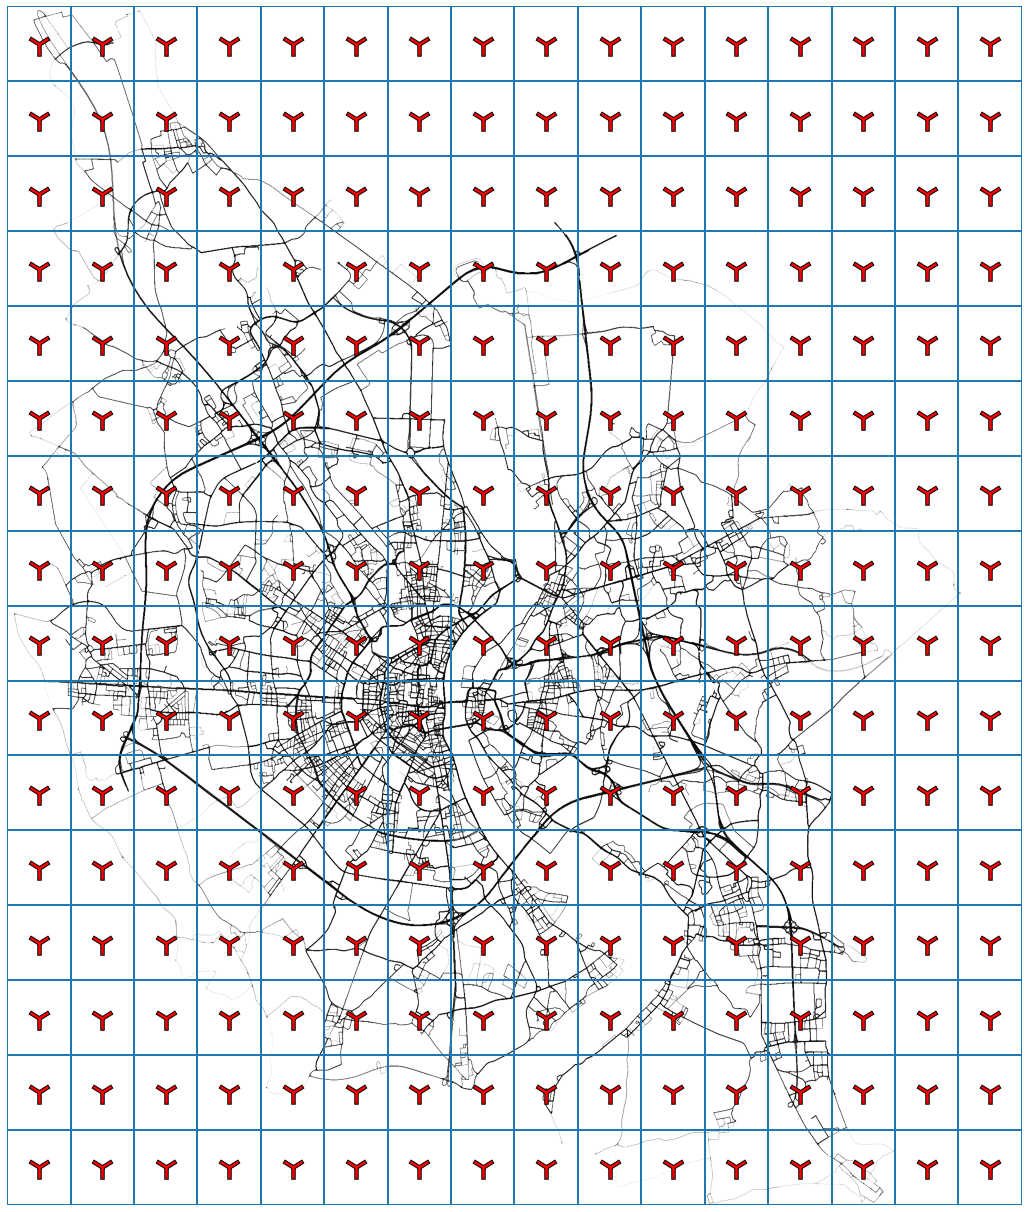

In [4]:
extent = [left, right, lower, upper]

gridsize = (1, 2)
fig = plt.figure(figsize=(40, 40))
ax = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax.imshow(img, extent=extent)



plt.vlines(df_grid['x'], ymin=lower, ymax=upper)
plt.hlines(df_grid['y'], xmin=left, xmax=right)


plt.scatter(df_BS['x'], df_BS['y'], color='red', s = 500, marker = "1",linewidths=2.5, zorder=5)
plt.scatter(df_BS['x'], df_BS['y'], color='black', s = 600, marker = "1",linewidths=4.5, zorder=1)
 
plt.axis('off')
plt.show()

## First  benchmarking

As a first thing, we inspect the optimal number of files in the import of the data. The original ~ 20 GB of data are imported either as one single file, two files or four files. The import is performed at fixed `{n_workers=4, nthreads=1, blocksize=9.455MB}` which are the intermediate values in the benchmark analysis performed successively.

We are interested in this preliminary optimization because the import of the files is time-consuming. By fixing the number of files as the optimal one we improve the following computations.



In [28]:
times_df = pd.read_csv('/dataNFS/import_times.csv', header=0)
times_df.rename(columns={'compute_time':'compute_time [s]'}, inplace=True)
times_df.groupby(by=['nthreads','n_workers','blocksize_MB','nfiles', 'npartitions']).agg(['mean','std']).round(3)


compute_time [s]        
                                                               mean     std
nthreads n_workers blocksize_MB nfiles npartitions                         
1        4         9.455        1      2147                 241.461   9.809
                                2      2146                 239.505   5.839
                                4      2144                 237.882  11.660
                                8      2144                 240.448   9.574
                                16     2144                 239.607   6.377

After splitting our original file in n = [1, 2, 4, 8, 16]  files, we computed the mean and the standard deviation of the time needed for importing and cleaning the data over 5 iterations, for each `nfiles` value.

We notice how the computing time doesn't vary significantly, we therefore choose to import a single file in the analyis.